# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [70]:
import pandas as pd
import numpy as np
import math
import json

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [71]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Exploring (portfolio)

Here I will just explore the three files (portfolio, profile, transcript).

**portfolio.json**
- id (string) - offer id
- offer_type (string) - type of offer ie BOGO, discount, informational
- difficulty (int) - minimum required spend to complete an offer
- reward (int) - reward given for completing an offer
- duration (int) - time for offer to be open, in days
- channels (list of strings)

In [72]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [73]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [74]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


# Exploring (profile)

**profile.json**
- age (int) - age of the customer
- became_member_on (int) - date when customer created an app account
- gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
- id (str) - customer id
- income (float) - customer's income

In [75]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [76]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [77]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


# Exploring (transcript)

**transcript.json**
- event (str) - record description (ie transaction, offer received, offer viewed, etc.)
- person (str) - customer id
- time (int) - time in hours since start of test. The data begins at time t=0
- value - (dict of strings) - either an offer id or transaction amount depending on the record

In [78]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [79]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [80]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


# Data Preparation and Cleaning

## Portfolio Cleaning and Wrangling

Here I will do some data cleaning and wrangling on the "Protfolio" DataFrame to utilize it in showing better results.

**Cleaning channels Column**

In [81]:
# First I will copy the portfolio DataFrame
portfolio_clean_df = portfolio.copy()
unique_channel = set()

In [82]:
# identify the unique channels
for channel in portfolio_clean_df.channels:
    unique_channel = unique_channel.union(set(channel))

In [83]:
unique_channel

{'email', 'mobile', 'social', 'web'}

In [84]:
# break 'channels' column to multiple columns with 0s and 1s values
for ch in unique_channel:
    portfolio_clean_df[ch] = portfolio_clean_df['channels'].apply(lambda channel_value: 1 if ch in channel_value else 0)

**Cleaning 'offer_type' column**

In [85]:
# add offers_df clean columns to portfolio_clean_df
portfolio_clean_df = pd.concat([portfolio_clean_df, pd.get_dummies(portfolio_clean_df['offer_type'])], axis=1)

In [86]:
portfolio_clean_df

,reward,channels,difficulty,duration,offer_type,id,web,social,mobile,email,bogo,discount,informational
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,0,1,1,0,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,1,1,1,0,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,0,1,1,0,1,0


In [87]:
# Drop the column
portfolio_clean_df.drop(['channels'], axis = 1, inplace=True)

In [88]:
# view portfolio after cleaning data
portfolio_clean_df

,reward,difficulty,duration,offer_type,id,web,social,mobile,email,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,0,1,1,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,1,1,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,0,1,1,0,1,0


In [89]:
# check for duplicates and remove them if there's any
portfolio_clean_df.duplicated().sum()

0

In [90]:
# change 'id' column name to 'offer_id'
portfolio_clean_df.rename(columns={'id':'offer_id'}, inplace=True)

In [91]:
# view portfolio after cleaning data
portfolio_clean_df

,reward,difficulty,duration,offer_type,offer_id,web,social,mobile,email,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,0,1,1,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,1,1,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,0,1,1,0,1,0


## Profile Cleaning and Wrangling

In [92]:
# First I will copy the portfolio DataFrame
profile_clean_df = profile.copy()

In [93]:
profile_clean_df

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [94]:
# check for duplicates and remove them if there's any
profile_clean_df.duplicated().sum()

0

In [95]:
profile_clean_df['became_member_on']

0        20170212
1        20170715
2        20180712
3        20170509
4        20170804
           ...   
16995    20180604
16996    20180713
16997    20170126
16998    20160307
16999    20170722
Name: became_member_on, Length: 17000, dtype: int64

In [96]:
# Fix 'became_member_on' column's values data type (to date)
profile_clean_df['became_member_on'] = pd.to_datetime(profile_clean_df['became_member_on'], format='%Y%m%d').dt.date

In [97]:
profile_clean_df['became_member_on']

0        2017-02-12
1        2017-07-15
2        2018-07-12
3        2017-05-09
4        2017-08-04
            ...    
16995    2018-06-04
16996    2018-07-13
16997    2017-01-26
16998    2016-03-07
16999    2017-07-22
Name: became_member_on, Length: 17000, dtype: object

In [98]:
# break down and normalize 'gender' column to to 0s and 1s
gender_type = pd.get_dummies(profile_clean_df['gender'])
# Rename the columns
gender_type = gender_type.rename(columns={'F':'female', 'M':'male', 'O':'other_gender'})

In [99]:
profile_clean_df = pd.concat([profile_clean_df, gender_type], axis=1)

In [100]:
profile_clean_df

,gender,age,id,became_member_on,income,female,male,other_gender
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0,0,0
...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,1,0,0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,0,1,0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,0,1,0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,1,0,0


In [101]:
# Replace age of 118 with Nans
profile_clean_df['age'] = profile_clean_df['age'].replace(118,np.nan)

In [102]:
profile_clean_df

,gender,age,id,became_member_on,income,female,male,other_gender
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0,0,0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0,0,0
...,...,...,...,...,...,...,...,...
16995,F,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,1,0,0
16996,M,61.0,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,0,1,0
16997,M,49.0,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,0,1,0
16998,F,83.0,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,1,0,0


In [103]:
# break down age column to multiple columns based on age group
profile_clean_df['age_group']  = pd.cut(profile_clean_df['age'], bins=[15,40,60,118], labels=['Teen','Mature','Seniors'], right=False)

In [104]:
# add the column to profile_clean_df
profile_clean_df = pd.concat([profile_clean_df, pd.get_dummies(profile_clean_df['age_group'])], axis=1)

In [105]:
# change 'id' column name to 'user_id'
profile_clean_df.rename(columns={'id':'user_id'}, inplace=True)

In [106]:
profile_clean_df

,gender,age,user_id,became_member_on,income,female,male,other_gender,age_group,Teen,Mature,Seniors
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0,NaN,0,0,0
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0,Mature,0,1,0
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0,0,0,NaN,0,0,0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0,Seniors,0,0,1
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0,0,0,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
16995,F,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,1,0,0,Mature,0,1,0
16996,M,61.0,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,0,1,0,Seniors,0,0,1
16997,M,49.0,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,0,1,0,Mature,0,1,0
16998,F,83.0,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,1,0,0,Seniors,0,0,1


## Transcript Cleaning and Wrangling

In [107]:
# First I will copy the portfolio DataFrame
transcript_clean_df = transcript.copy()

In [108]:
transcript_clean_df

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [109]:
transcript_clean_df['offer_id'] = None
transcript_clean_df['amount_of_transaction'] =np.nan

In [110]:
transcript_clean_df

,person,event,value,time,offer_id,amount_of_transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,None,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,None,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,None,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,None,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,None,NaN
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,None,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,None,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,None,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,None,NaN


In [111]:
def offer_ids(transcript_clean_df):    
    '''
    INPUT:
    transcript_clean_df - (pandas dataframe) transcript as defined at the top of the notebook 
    
    OUTPUT:
    Non - in case if the key value of 'value' column is not offer id
    Offer id value - in case if the key value of 'value' column is offer id

    '''
    
    if transcript_clean_df['event'] == 'transaction':
        return None
    else:
        if 'offer id' in transcript_clean_df['value'].keys() :
            return transcript_clean_df['value']['offer id']
        else:
            return transcript_clean_df['value']['offer_id']
        

In [112]:
def transactions_amount(transcript_clean_df):
    '''
    INPUT:
    transcript_clean_df - (pandas dataframe) transcript as defined at the top of the notebook 
    
    OUTPUT:
    Nan - in case if the key value of 'value' column is not transaction
    amount_of_transaction - in case if the key value of 'value' column is transaction

    '''
    if transcript_clean_df['event'] != 'transaction':
        return np.nan
    else:
        return transcript_clean_df['value']['amount']

In [113]:
# breaking down 'value' column to create 'offer_id' and 'amount_of_transaction' columns
transcript_clean_df['amount_of_transaction'] = transcript_clean_df.apply(lambda amount : transactions_amount(amount),axis=1)

transcript_clean_df['offer_id'] = transcript_clean_df.apply(lambda offer : offer_ids(offer),axis=1)


In [114]:
# break down event column to multiple columns and convert values to 0s and 1s
event_dum = pd.get_dummies(transcript_clean_df['event'])

In [115]:
# merge event_dum with transcript_clean_df
transcript_clean_df = pd.concat([transcript_clean_df, event_dum], axis=1)

In [116]:
# drop value and event columns
transcript_clean_df.drop(['value'], axis = 1, inplace=True)
transcript_clean_df.drop(['event'], axis = 1, inplace=True)

In [117]:
# check for duplicates
transcript_clean_df.duplicated().sum()

397

In [118]:
# removing duplicates
transcript_clean_df.drop_duplicates(keep="first", inplace=True)

In [119]:
# check for duplicates
transcript_clean_df.duplicated().sum()

0

In [120]:
# change 'person' column's name to 'user_id'
transcript_clean_df.rename(columns={'person':'user_id'}, inplace=True)

## Merging the three DataFrames together

In [121]:
df = transcript_clean_df.merge(portfolio_clean_df,on='offer_id', how='left')

In [122]:
df = df.merge(profile_clean_df, on='user_id', how='left')

In [123]:
df.columns

Index(['user_id', 'time', 'offer_id', 'amount_of_transaction',
       'offer completed', 'offer received', 'offer viewed', 'transaction',
       'reward', 'difficulty', 'duration', 'offer_type', 'web', 'social',
       'mobile', 'email', 'bogo', 'discount', 'informational', 'gender', 'age',
       'became_member_on', 'income', 'female', 'male', 'other_gender',
       'age_group', 'Teen', 'Mature', 'Seniors'],
      dtype='object')

# Data Visualization and Analysis

## Q: What is the majority of starbucks customers? (Male/Female/O)

Text(0.5, 1.0, 'Starbucks Customers based on gender')

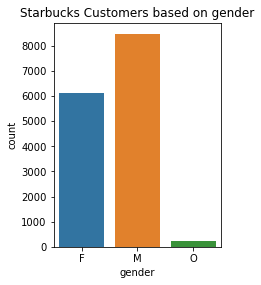

In [124]:
plt.figure(figsize = [3, 14])

ax = plt.subplot(3, 1, 2)
sns.countplot(data = profile_clean_df, x = 'gender')
ax.set_title('Starbucks Customers based on gender')

From the bar chart we can clearly say that the major of Starbucks customers are Male.

## Q: From which age group comes the majority of Starbuck customers? (Teen/Mature/Seniors)

Text(0.5, 1.0, 'Starbucks Customers based on age group')

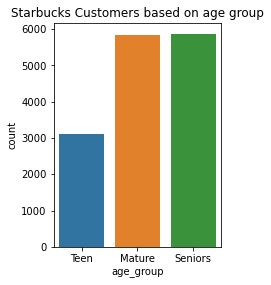

In [125]:
plt.figure(figsize = [3, 14])

ax = plt.subplot(3, 1, 2)
sns.countplot(data = profile_clean_df, x = 'age_group')
ax.set_title('Starbucks Customers based on age group')

Text(0.5, 0, 'Customer Age')

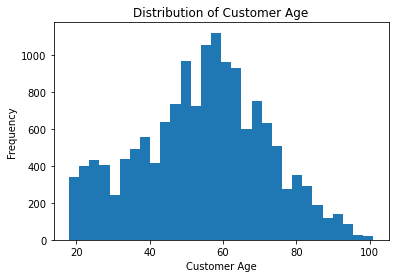

In [126]:
plt = profile_clean_df['age'].plot(kind='hist', 
                                        bins=30, 
                                        title='Distribution of Customer Age')
plt.set_xlabel("Customer Age")

The majority of Starbucks customers are Matures and seniors. There are also few Teen customers.

## Q: What is the offer preferred by customers? and Who from customer age group is active in completing the offers?

Text(0, 0.5, '')

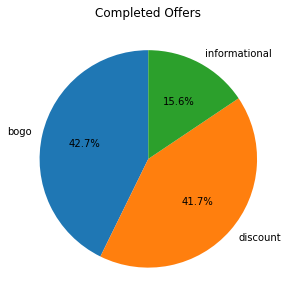

In [49]:
plt= df.groupby('offer_type')['offer completed'].count().plot(kind='pie' ,
                                                               figsize=(5,5)  , 
                                                               startangle=90, 
                                                               autopct='%1.1f%%' , 
                                                               title= "Completed Offers")
plt.set_ylabel('')

Based on user's completed offers, we can say BOGO and discount offers are the most preferred because their percentages are high.

Text(0, 0.5, '')

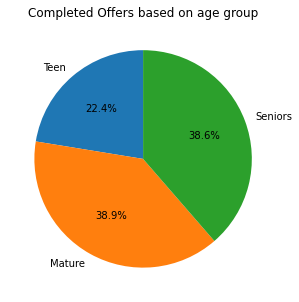

In [50]:
plt= df.groupby('age_group')['offer completed'].count().plot(kind='pie' ,
                                                               figsize=(5,5)  , 
                                                               startangle=90, 
                                                               autopct='%1.1f%%' , 
                                                               title= "Completed Offers based on age group")
plt.set_ylabel('')

It's clear that Teens are the least active in completing offers. Seniors and Matures are kind of the same. So Starbucks should not target Teens in sending the offer.

# Data Model

## Q: Who's from the customer really interacting with the recieved offers?

I will dive inside transcripts dataFrame to check if the customer viewes the offer and utilize it by checking 'offer completed' column value to support my model.

In [127]:
def fetching_completed_and_viewed_offers(df, offer_target_columns):
    '''
    This function creates offer_df DataFrame which contains 'offer_id', 'user_id', 
    'offer completed' columns from df
    
    INPUT:
    df - (pandas dataframe) df is the final dataframe result after cleaning
    offer_target_columns - list of columns offer_df should contain
    
    OUTPUT:
    offer_df - (pandas dataframe) contains completed and viewed offers
    
    '''
    # Get offer viewed 
    offer_viewed = df[df['offer viewed']==1]
    # rename 'offer completed' column to replace it
    offer_viewed.rename(columns={'offer completed':'completed_offer'}, inplace=True)
    # break 'offer completed' column down from df to multiple columns
    offer_completed= df[df['offer completed']==1][offer_target_columns]
    # drop the old 'completed offers' column
    offer_viewed.drop(['completed_offer'], axis = 1, inplace=True)
    
    # merge both viewed and completed offers into one dataframe
    offer_df = offer_viewed.merge(offer_completed,right_on=['offer_id','user_id'],
                                  left_on=['offer_id','user_id'],how='left')
    # overwrite Nans with 0s in 'offer completed' column
    offer_df['offer completed'].fillna(0,inplace=True)
    
    return offer_df

offer_target_columns = ['offer_id', 'user_id', 'offer completed']
offer_df = fetching_completed_and_viewed_offers(df, offer_target_columns)

/Users/sara/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/sara/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [128]:
offer_df.columns

Index(['user_id', 'time', 'offer_id', 'amount_of_transaction',
       'offer received', 'offer viewed', 'transaction', 'reward', 'difficulty',
       'duration', 'offer_type', 'web', 'social', 'mobile', 'email', 'bogo',
       'discount', 'informational', 'gender', 'age', 'became_member_on',
       'income', 'female', 'male', 'other_gender', 'age_group', 'Teen',
       'Mature', 'Seniors', 'offer completed'],
      dtype='object')

In [129]:
# Drop non related columns
offer_df.drop(['user_id',
               'gender',
               'offer_id',
               'offer received',
               'offer viewed',
               'amount_of_transaction',
               'age',
               'age_group',
               'became_member_on',
               'offer_type',
               'transaction'], axis = 1, inplace=True)

In [130]:
# overcome missing values with mean value
income_mean = offer_df.income.mean()
offer_df.income.fillna(income_mean, inplace=True)

## Create test and train datasets

In [131]:
# split and returns training and testing dataset
x_train, x_test, y_train, y_test = train_test_split(offer_df.drop(['offer completed'], 
                                                                  axis = 1), 
                                                    offer_df['offer completed'], 
                                                    test_size=40, 
                                                    random_state=40)

In [132]:
# classifiers
ADA, GNB = AdaBoostClassifier(), GaussianNB()

classifier_results = pd.DataFrame(columns =['Classifier', 'Training Accuracy','Testing Accuracy'])
classifiers = {'AdaBoost':ADA, 'Gaussian Naive Bayes':GNB}

In [133]:
offer_df

,time,reward,difficulty,duration,web,social,mobile,email,bogo,discount,informational,income,female,male,other_gender,Teen,Mature,Seniors,offer completed
0,0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,53000.00000,0,1,0,0,0,1,1.0
1,0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,53000.00000,0,1,0,0,0,1,1.0
2,0,0.0,0.0,3.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,52000.00000,0,0,1,0,1,0,0.0
3,0,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,57000.00000,1,0,0,0,0,1,1.0
4,0,10.0,10.0,7.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,30000.00000,1,0,0,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65575,714,0.0,0.0,3.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,66398.21503,0,0,0,0,0,0,0.0
65576,714,0.0,0.0,4.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,81000.00000,1,0,0,0,0,1,0.0
65577,714,0.0,0.0,3.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,113000.00000,1,0,0,0,0,1,0.0
65578,714,0.0,0.0,4.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,68000.00000,0,1,0,0,1,0,0.0


In [134]:
for classifier_name, classifier in classifiers.items():
        classifier_trian = classifier.fit(x_train, y_train)
        
        predict_train = classifier_trian.predict(x_train)
        predict_test = classifier_trian.predict(x_test)

        # accuracy of train and test dataset
        train_accuracy = accuracy_score(y_train, predict_train)
        test_accuracy = accuracy_score(y_test, predict_test)

        results = {'Classifier': classifier_name,'Accuracy of Training': train_accuracy, 'Accuracy of Testing' :test_accuracy}
        print('Test', results)
        # append results to classifier_results
        classifier_results = classifier_results.append(pd.DataFrame(results,index=[0]), 
                                                       ignore_index=True)

Test {'Classifier': 'AdaBoost', 'Accuracy of Training': 0.8077967653341471, 'Accuracy of Testing': 0.8}
Test {'Classifier': 'Gaussian Naive Bayes', 'Accuracy of Training': 0.7333231614281355, 'Accuracy of Testing': 0.775}


In [135]:
classifier_results

,Classifier,Training Accuracy,Testing Accuracy,Accuracy of Training,Accuracy of Testing
0,AdaBoost,NaN,NaN,0.807797,0.800
1,Gaussian Naive Bayes,NaN,NaN,0.733323,0.775


## Evaluation

In [ ]:
# model evaluation
model = GridSearchCV(ADA, 
                     param_grid={'n_estimators': [50, 100,150,200],
                                 'learning_rate' : [0.01,0.05,0.1,0.3,1],
                                 'algorithm':['SAMME', 'SAMME.R']}, 
                     n_jobs = -1, scoring='accuracy')
model.fit(x_train,y_train)

In [ ]:
model.best_params_

In [ ]:
ADA_clarified =AdaBoostClassifier(algorithm='SAMME.R',
                                learning_rate=0.3, 
                                n_estimators=200)

classifier_trian = ADA_clarified.fit(x_train, y_train)
predict_train = classifier_trian.predict(x_train)
predict_test = classifier_trian.predict(x_test)

# accuracy of train and test dataset
train_accuracy = accuracy_score(y_train, predict_train)
test_accuracy = accuracy_score(y_test, predict_test)

results = {'Classifier': 'adaBoost',
           'Accuracy of Training': train_accuracy,
           'Accuracy of Testing' :test_accuracy}

In [ ]:
results

In [ ]:
model.best_params_

After using Grid Search, there's an increase in the accuracy.

# Bottom line

1. Offers should be sent to men and senior customers because of the big number of offers completed by these categories.
2. The winner offer is (BOGO) as it is the most popular one. 
3. Most of the completed offers are done by male customers. Because of that Starbucks should target males in sending offers.
4. For the age group, senior(old) customers are more into completing the offers. Starbucks should target them in sending offers.

# Enhancement

Results can be enhanced if more features exist in the profile dataframe. It would be awesome if Starbucks provided more informations about their customers so that we can use it in this analysis.